04.11.2020 KIM

This is copy from Udacity course of "Intro to TensorFlow for Deep Learning"

Code source: Lesson 8 Topic "Time Series Forecasting"

Instructor: Aurélien Géron is a Machine Learning consultant, author of the best-selling O'Reilly book "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow". A former Googler, he led YouTube's video classification team from 2013 to 2016. He was also a founder and CTO of Wifirst from 2002 to 2012, a leading Wireless ISP in France. Before this he worked as a consultant in a variety of domains: finance (JP Morgan and Société Générale), defense (Canada's DOD), and healthcare (blood transfusion). He also published a few technical books (on C++, WiFi, and Internet architectures), and he is a lecturer at the Dauphine University in Paris. He currently lives in New Zealand with his wife and 3 children.

In [52]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras

In [58]:
## Functions for Create Data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    #plt.plot(figsize = (10,6))
    plt.plot(time[start:end],series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    #plt.show()
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality (time, period, amplitude=1, phase=0):
    season_time = ( (time+phase)%period )/period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [54]:
# Creating Input vector preparing for forecasting (create window)

# sequence to 1
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# for rnn sequence to sequence
def seq2seq_window_dataset(series, window_size, 
                           batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# for stateful rnn, consecutive batch 
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

# for reset state every epoch
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
        
# prediction
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# evaluation
def get_mae(forecast, valid):
    errors = forecast - valid
    abs_errors = np.abs(errors)
    ret = abs_errors.mean()
    return keras.metrics.mean_absolute_error(valid, forecast).numpy()


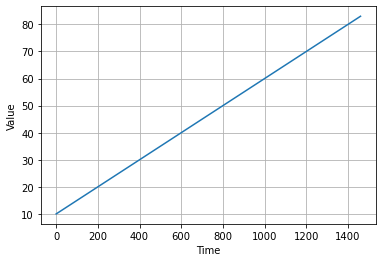

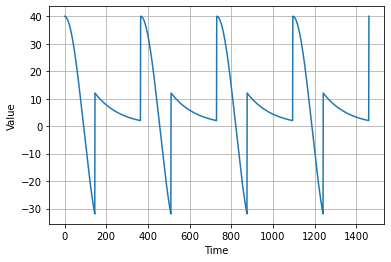

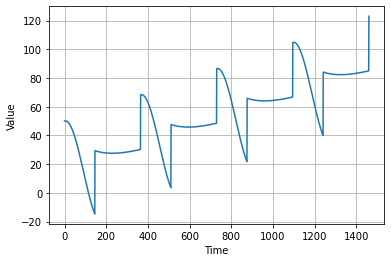

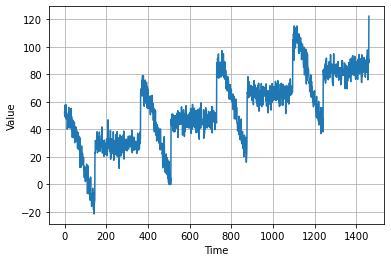

In [57]:
# Create Data using functions
time = np.arange(4*365 + 1)
baseline = 10
amplitude = 40
noise_level = 5

series = baseline + trend(time, 0.05)
plot_series(time, series)

series_with_seaonality = seasonality(time, 365, amplitude)
plot_series(time, series_with_seaonality)

series_with_trend_seasonality = series + series_with_seaonality
plot_series(time, series_with_trend_seasonality)

series_with_noise = series_with_trend_seasonality + white_noise(time, noise_level, seed=42)
plot_series(time, series_with_noise)


In [59]:
time = np.arange(4*365 + 1)
series = series_with_noise

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

x_train.shape, x_valid.shape

((1000,), (461,))

## Naive Forecast

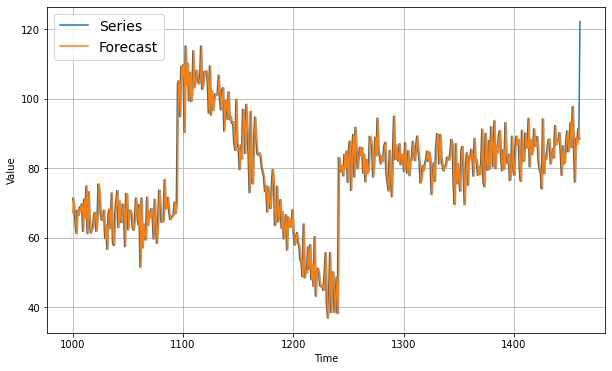

In [41]:
naive_forecast = series[split_time-1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, naive_forecast, label = "Forecast")
plt.show()

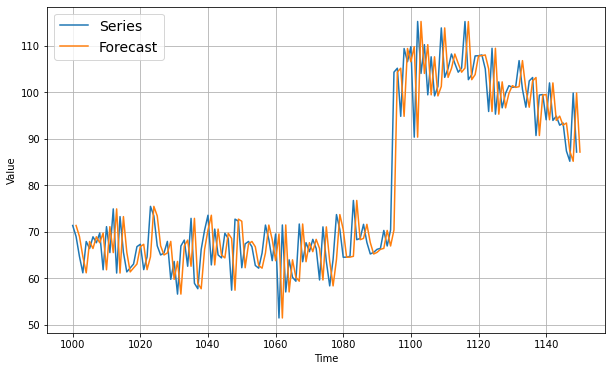

In [42]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [46]:
np.abs(naive_forecast - x_valid).mean()
get_mae(naive_forecast, x_valid)

5.9379085153216735

In [48]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.937908515321679

## Moving average (part3)

In [54]:
def moving_average_forecast(series, window_size):
    forecasts = []  #mean of the last window_size values
    for time in range(len(series) - window_size):
        forecast.append( series[time:(time+window_size)].mean())
    return forecasts

def moving_average_forecast(series, window_size):
    """ If window_size=1, then this is equivalent to naive forecast
    This implementation is *much* faster than the previous one """
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size


In [53]:
moving_average_forecast(series, 30).shape, series.shape

((1431,), (1461,))

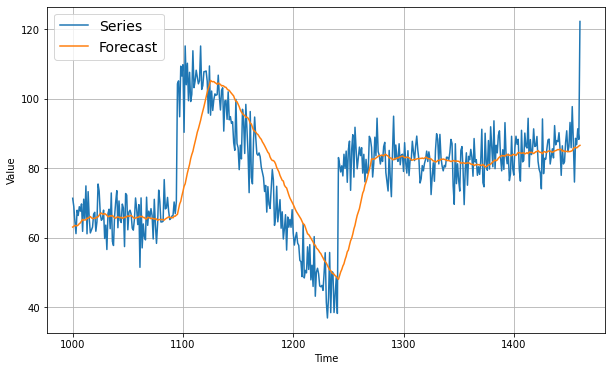

In [55]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Forecast")

In [56]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.142418570620787

(1096,) (1096,) (1461,)
(1096,) (1096,)


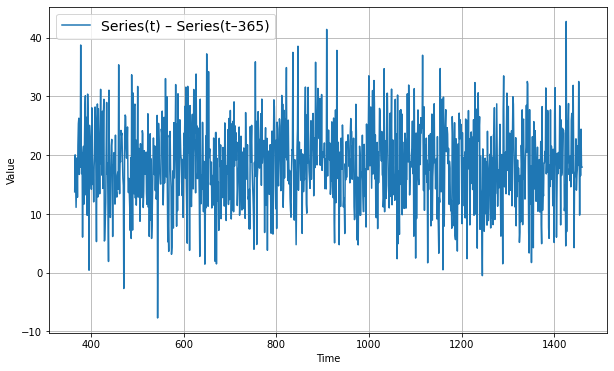

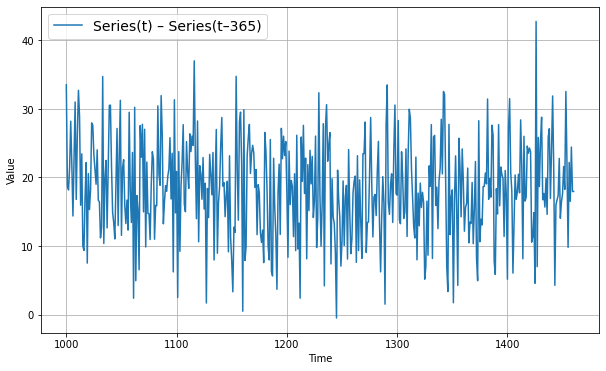

(461,) (461,)
[3 4 5 6 7 8 9] [0 1 2 3 4 5 6]


array([3, 3, 3, 3, 3, 3, 3])

In [71]:
diff_series = (series[365:] - series[:-365])
print(series[365:].shape, series[:-365].shape, series.shape)
diff_time = time[365:]
print(diff_series.shape, diff_time.shape)
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()
print(time_valid.shape, diff_series[split_time-365:].shape)

x = np.arange(10)
x[3:], x[:-3]
print(x[3:], x[:-3])
x[3:] - x[:-3]

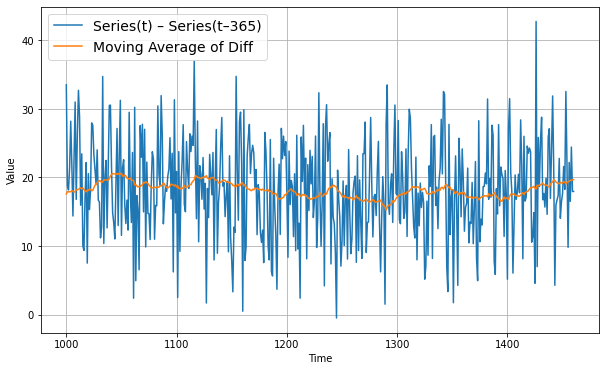

In [68]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

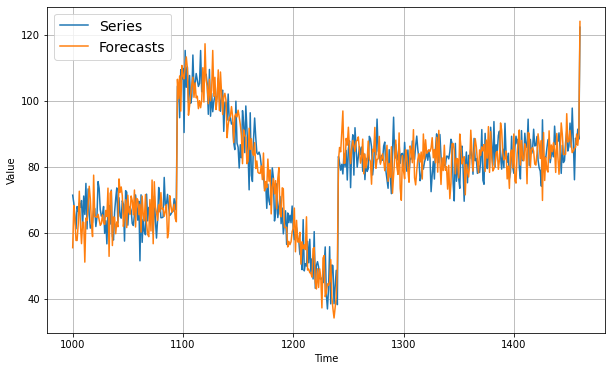

5.8393105629958955

In [69]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

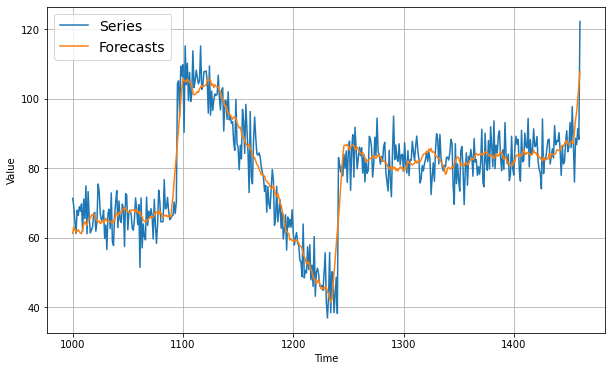

4.566859958970771

In [70]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

## Time Window (part4)

In [104]:
dataset = tf.data.Dataset.range(10)

# shift by 1
data = dataset.window(5, shift=1)
for window in data:
    for val in window:
        print(val.numpy(), end=" ")
    print()
    
# shift by 2, drop_remainder ON
data = dataset.window(5, shift=2, drop_remainder=True)
for window_dataset in data:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()
    
# flat_map, shift by 1
data = dataset.window(5, shift=1, drop_remainder=True)
data = data.flat_map(lambda window: window.batch(5))
for window in data:
    print(window.numpy())

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 
0 1 2 3 4 
2 3 4 5 6 
4 5 6 7 8 
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [96]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [109]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
#dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)

for x, y in dataset:
    print(x.numpy(), y.numpy())

[1 2 3 4] [5]
[3 4 5 6] [7]
[5 6 7 8] [9]
[4 5 6 7] [8]
[2 3 4 5] [6]
[0 1 2 3] [4]


In [106]:
dataset = tf.data.Dataset.range(11)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(3).prefetch(1)

for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[2 3 4 5]
 [6 7 8 9]
 [5 6 7 8]]
y = [[ 6]
 [10]
 [ 9]]
x = [[4 5 6 7]
 [0 1 2 3]
 [3 4 5 6]]
y = [[8]
 [4]
 [7]]
x = [[1 2 3 4]]
y = [[5]]


In [112]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine learning (part5)

### Linear Model 

In [16]:
def get_learning_rate(train_set, output, window_size):
    
    model = keras.models.Sequential([
        keras.layers.Dense(output, input_shape=[window_size])
    ])
    lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch : 1e-6 * 10**(epoch/30))
    optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
    model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
    history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])
    
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-6, 1e-3, 0, 20])
    plt.show()
    return history


def get_best_model(train_set, valid_set, output, window_size, lr=1e-6):
    
    model = keras.models.Sequential([
        keras.layers.Dense(output, input_shape=[window_size])
    ])
    early_stopping = keras.callbacks.EarlyStopping(patience=10)
    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
    model.fit(train_set, epochs=500,
              validation_data = valid_set,
              callbacks = [early_stopping])
    return model

In [116]:
import tensorflow as tf
keras = tf.keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1, input_shape=[window_size])
        ])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(), 
            optimizer = optimizer,
            metrics =['mae'] )

model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 47ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 1s 29ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 1s 36ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 1s 30ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 1s 32ms/s

In [121]:
import tensorflow as tf
keras = tf.keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-6 * 10**(epoch/30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])


Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 67.6867 - mae: 68.1863 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 52.3572 - mae: 52.8561 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 34.6465 - mae: 35.1446 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 17.6521 - mae: 18.1484 - lr: 1.2589e-06278 - mae: 20.7
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 8.4604 - mae: 8.9488 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 7.9765 - mae: 8.4627 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 7.9201 - mae: 8.4035 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 1s 24ms/step - loss: 7.8785 - mae: 8.3609 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 7.8191 

(1e-06, 0.001, 0.0, 20.0)

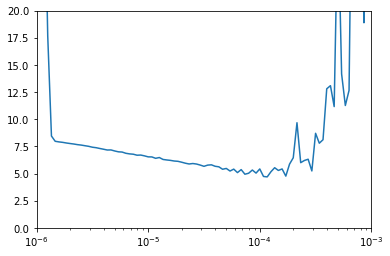

In [122]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [133]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile( loss = keras.losses.Huber(),
            optimizer = optimizer,
            metrics =['mae'])
early_stop = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500, 
          validation_data = valid_set, 
          callbacks =[early_stop])

Epoch 1/500
31/31 [==============================] - 2s 49ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 1s 39ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 1s 39ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 1s 33ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 1s 36ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 1s 34ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 1s 29ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 1s 39ms/s

In [30]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [126]:
model_forecast(model, series[split_time-window_size:-1], window_size).shape

(461, 1)

5.166266

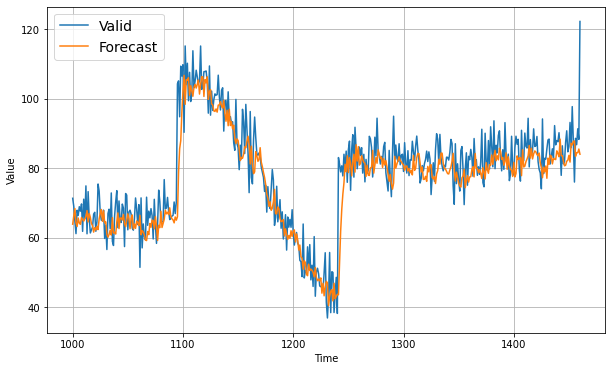

In [134]:
linear_forecasts = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, linear_forecasts, label="Forecast")

get_mae(linear_forecasts, x_valid)
keras.metrics.mean_absolute_error(x_valid, linear_forecasts).numpy()

### Dense Model Forecasting

In [142]:
# Get optimal learning rate 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 42ms/step - loss: 43.8270 - mae: 44.3262 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 1s 34ms/step - loss: 41.5210 - mae: 42.0202 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 38.6253 - mae: 39.1248 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 35.3202 - mae: 35.8201 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 1s 36ms/step - loss: 31.5905 - mae: 32.0903 - lr: 1.5849e-07706 - mae:
Epoch 6/100
31/31 [==============================] - 1s 37ms/step - loss: 27.4033 - mae: 27.9022 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 1s 27ms/step - loss: 22.7830 - mae: 23.2804 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 1s 36ms/step - loss: 17.7632 - mae: 18.2594 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 1s 26ms/step - loss: 12.6

(1e-07, 0.005, 0.0, 30.0)

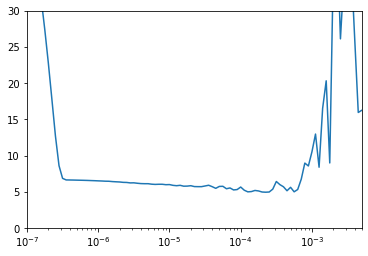

In [144]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [145]:
# Get best model with optimal learning rate
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500, 
          validation_data = valid_set,
          callbacks=[early_stopping])


Epoch 1/500
31/31 [==============================] - 1s 45ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5124 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 2s 49ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 1s 40ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 1s 47ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 2s 55ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 2s 52ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 2s 49ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 2s 55ms/step - loss:

In [146]:
dense_forecasts = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

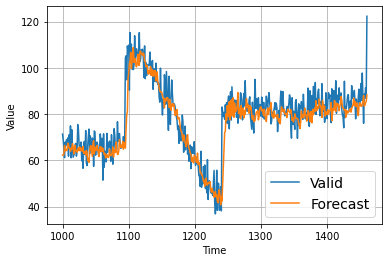

In [149]:
plt.plot(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, dense_forecasts, label="Forecast")

In [151]:
keras.metrics.mean_absolute_error(x_valid, dense_forecasts).numpy()

5.2025537

## Forecasting with an RNN (part6)

### Simple rnn

only for short-term pattern learning(batch size), stateless rnn, shuffled batch(no consequence batch to batch), batch size limit

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                    "my_checkpoint", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=500, 
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])


In [ ]:
simple_rnn_forecasts = model_forecast(model, series[], window_size)[:, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, simple_rnn_forecasts, label="Forecast")

keras.metrics.mean_absolute_error(x_valie, simple_rnn_forecasts).numpy()

### Sequence-to-Sequence Forecasting

In [152]:
def seq2seq_window_dataset(series, window_size, 
                           batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [158]:
import tensorflow as tf
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 5,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]
  [4]
  [5]]]
Y: [[[2]
  [3]
  [4]
  [5]
  [6]]]
X: [[[2]
  [3]
  [4]
  [5]
  [6]]]
Y: [[[3]
  [4]
  [5]
  [6]
  [7]]]
X: [[[4]
  [5]
  [6]
  [7]
  [8]]]
Y: [[[5]
  [6]
  [7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]
  [3]
  [4]]]
Y: [[[1]
  [2]
  [3]
  [4]
  [5]]]
X: [[[3]
  [4]
  [5]
  [6]
  [7]]]
Y: [[[4]
  [5]
  [6]
  [7]
  [8]]]


In [153]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 423ms/step - loss: 52.3617 - mae: 52.8613 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 4s 463ms/step - loss: 25.4934 - mae: 25.9891 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 4s 526ms/step - loss: 23.2908 - mae: 23.7849 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 3s 376ms/step - loss: 20.9775 - mae: 21.4704 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 3s 363ms/step - loss: 19.4449 - mae: 19.9359 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 3s 388ms/step - loss: 18.6296 - mae: 19.1188 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 4s 500ms/step - loss: 18.0603 - mae: 18.5500 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 4s 451ms/step - loss: 17.5912 - mae: 18.0800 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 3s 412ms/step - loss: 17.1803 - mae: 17.6696 

(1e-07, 0.0001, 0.0, 30.0)

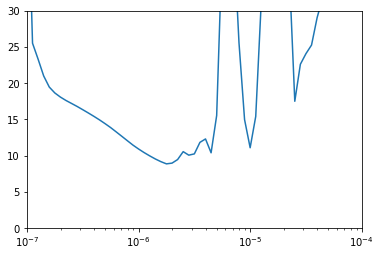

In [154]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [155]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, 
                    validation_data= valid_set,
                    callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 5s 649ms/step - loss: 54.1429 - mae: 54.6414 - val_loss: 17.9208 - val_mae: 18.4156
Epoch 2/500
8/8 [==============================] - 5s 611ms/step - loss: 34.1722 - mae: 34.6694 - val_loss: 20.5482 - val_mae: 21.0441
Epoch 3/500
8/8 [==============================] - 6s 726ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8713 - val_mae: 38.3707
Epoch 4/500
8/8 [==============================] - 4s 562ms/step - loss: 21.0646 - mae: 21.5579 - val_loss: 25.2685 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 4s 561ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3556 - val_mae: 15.8505
Epoch 6/500
8/8 [==============================] - 5s 574ms/step - loss: 15.0383 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 4s 502ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 7s 839ms

5.4588604

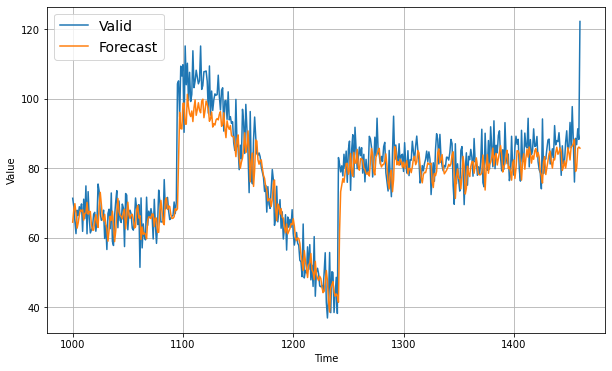

In [156]:
seq2seq_simple_rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
seq2seq_simple_rnn_forecast = seq2seq_simple_rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, seq2seq_simple_rnn_forecast, label="Forecast")

keras.metrics.mean_absolute_error(x_valid, seq2seq_simple_rnn_forecast).numpy()

## Forecast with stateful rnn (part7)

what is stateful rnn? for long-term pattern learning, batch size can be grown
consequently batch to batch, no shuffled, previous batch give effect to current batch, next batch is next sequence of current batch. each epoch reset state(reset callback needed), limit? yes, not remember

In [159]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [160]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
                "my_checkpoint7.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

In [ ]:
model = keras.models.load_model("my_checkpoint7.h5")
model.reset_states()
stateful_rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
stateful_rnn_forecast = stateful_rnn_forecast[0, split_time - 1:-1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, stateful_rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, stateful_rnn_forecast).numpy()

## Forecasting with an LSTM (part8)

### LSTM RNN Forecasting

for learning long-term pattern, long-term state vector (forget gate, on or off)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint8.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

In [ ]:
model = keras.models.load_model("my_checkpoint8.h5")
lstm_forecast = model.predict(series[np.newaxis, :, np.newaxis])
lstm_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

## Forecasting with CNN (part9)

CNN, kernal size and number(multivariant) of kernal(=filter), causal padding, stride, (WaveNet, dilation rate)

### preprocessing with cnn layer, lstm

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# stateless train set -no consecutive batch = shuffled
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation ='relu',
                       input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 8s 1s/step - loss: 87.8346 - mae: 88.3341 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 7s 913ms/step - loss: 87.1197 - mae: 87.6191 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 8s 950ms/step - loss: 85.9241 - mae: 86.4234 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 6s 802ms/step - loss: 84.3720 - mae: 84.8713 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 6s 799ms/step - loss: 82.4702 - mae: 82.9696 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 7s 863ms/step - loss: 80.2434 - mae: 80.7427 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 7s 850ms/step - loss: 77.7459 - mae: 78.2453 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 6s 725ms/step - loss: 75.0957 - mae: 75.5952 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 7s 900ms/step - loss: 72.4508 - mae: 72.9504 - l

(1e-08, 0.0001, 0.0, 30.0)

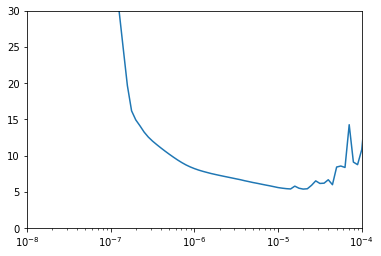

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, 
                       strides=1, padding='causal',
                       activation='relu',
                       input_shape= [None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)    
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint9.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [model_checkpoint, early_stopping])

Epoch 1/500
8/8 [==============================] - 11s 1s/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 8s 949ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 10s 1s/step - loss: 17.3630 - mae: 17.8585 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 9s 1s/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 9s 1s/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 9s 1s/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 8s 954ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 8s 964ms/step - loss: 

In [42]:
model = keras.models.load_model('my_checkpoint9.h5')

cnn_lstm_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
cnn_lstm_forecast = cnn_lstm_forecast[split_time - window_size:-1, -1, 0]


12.171149935369574

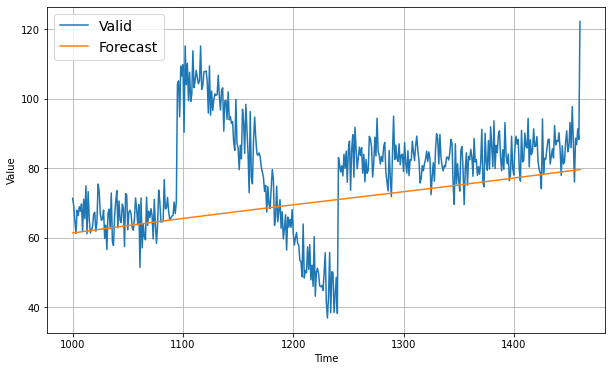

In [43]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, cnn_lstm_forecast, label ="Forecast")

get_mae(x_valid, cnn_lstm_forecast)

### fully Convolutional Forecasting

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in [1, 2, 4, 8 ,16, 32]:
    model.add(keras.layers.Conv1D(filters=32, 
                        kernel_size=2,
                        strides=1, 
                        padding='causal',
                        activation='relu',
                        dilation_rate = dilation_rate))

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10 **(epoch/30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics =['mae'])

history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])


Epoch 1/100
8/8 [==============================] - 2s 226ms/step - loss: 42.2341 - mae: 42.7330 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 1s 187ms/step - loss: 41.8293 - mae: 42.3284 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 2s 190ms/step - loss: 41.4367 - mae: 41.9357 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 2s 199ms/step - loss: 41.0108 - mae: 41.5098 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 2s 189ms/step - loss: 40.4787 - mae: 40.9776 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 2s 189ms/step - loss: 39.7341 - mae: 40.2328 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 1s 175ms/step - loss: 38.5884 - mae: 39.0871 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 1s 187ms/step - loss: 36.6836 - mae: 37.1823 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 2s 201ms/step - loss: 33.3644 - mae: 33.8629 

(0.0001, 0.1, 0.0, 30.0)

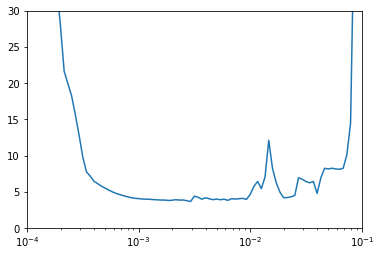

In [45]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in [1, 2, 4, 8, 16, 32]:
    model.add(keras.layers.Conv1D(filters=64,
                                  kernel_size=2,
                                  strides=1,
                                  padding='causal',
                                  activation ='relu',
                                  dilation_rate=dilation_rate ))

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
            "my_checkpoint.h5", save_best_only = True)
optimizer = keras.optimizers.Adam(lr=3e-4)

model.compile(loss = keras.losses.Huber(),
             optimizer= optimizer,
             metrics=['mae'])

history = model.fit(train_set, epochs = 500,
                    validation_data = valid_set,
                    callbacks =[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 490ms/step - loss: 39.2086 - mae: 39.7074 - val_loss: 68.5758 - val_mae: 69.0758
Epoch 2/500
8/8 [==============================] - 3s 389ms/step - loss: 34.2243 - mae: 34.7229 - val_loss: 54.0968 - val_mae: 54.5968
Epoch 3/500
8/8 [==============================] - 3s 411ms/step - loss: 24.5304 - mae: 25.0271 - val_loss: 30.6288 - val_mae: 31.1253
Epoch 4/500
8/8 [==============================] - 3s 405ms/step - loss: 18.8119 - mae: 19.3074 - val_loss: 30.0073 - val_mae: 30.5051
Epoch 5/500
8/8 [==============================] - 3s 406ms/step - loss: 16.2846 - mae: 16.7788 - val_loss: 22.5748 - val_mae: 23.0690
Epoch 6/500
8/8 [==============================] - 3s 428ms/step - loss: 13.1357 - mae: 13.6259 - val_loss: 16.5849 - val_mae: 17.0761
Epoch 7/500
8/8 [==============================] - 3s 415ms/step - loss: 9.9886 - mae: 10.4760 - val_loss: 11.8202 - val_mae: 12.3064
Epoch 8/500
8/8 [==============================] - 3s 42

In [47]:
model = keras.models.load_model("my_checkpoint.h5")

full_cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
full_cnn_forecast = full_cnn_forecast[split_time - window_size:-1, -1, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=11.900274>

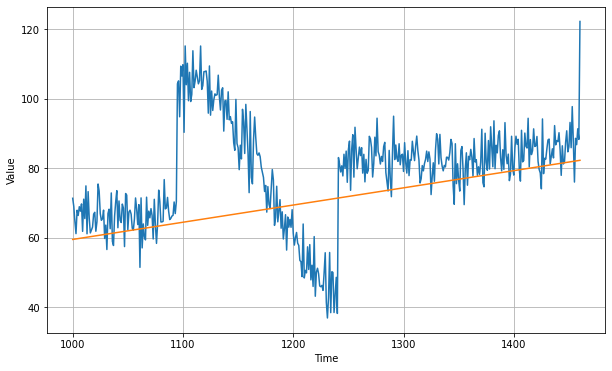

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, full_cnn_forecast)

keras.metrics.mean_absolute_error(x_valid, full_cnn_forecast)